<a href="https://colab.research.google.com/github/AnshSharma16/PicassoVision/blob/main/NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IPython.display** provides tools to display images, audio, and rich output in
Jupyter notebooks.

**display()** can be used to show images dynamically.

**matplotlib.pyplot** is a popular plotting library for visualizing data.

**mpl.rcParams** is used to modify default settings in Matplotlib:
*   **figure.figsize = (12, 12):** Sets the default figure size to 12x12 inches.
*   **axes.grid = False:** Disables grid lines on all plots.

**numpy** is a fundamental library for numerical operations in Python.

**PIL.Image** module from the Pillow library is used for image processing.
It helps in opening, manipulating, and saving images.

**time** module is used for handling time-related operations.
Useful for measuring execution time **(time.time())** or adding delays** (time.sleep())**.

**functools** module provides tools for working with functions.
Commonly used for memorization (**functools.lru_cache**) and function decorators (**functools.partial**).


In [1]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [2]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

Tensors (especially image tensors in ML/DL) usually contain values between 0 and 1 (normalized pixel values).
Multiplying by 255 scales the values back to the standard RGB pixel range (0–255).

Converts the tensor into a NumPy array with a data type of uint8 (unsigned 8-bit integer).
The uint8 format ensures that each pixel is correctly represented in the range 0-255.

Images are usually 3D arrays (Height × Width × Channels for RGB).
Sometimes, a batch dimension (1 × Height × Width × Channels) is included in tensors used in ML.
If an extra batch dimension exists (shape[0] == 1), it removes it by doing **tensor = tensor[0].**

Uses PIL.Image.fromarray() to convert the NumPy array back into a PIL Image.
This allows the image to be displayed, saved, or processed further.**bold text**

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Downloads the Vishnu brass statue image from the given URL.

Stores it with the filename vishnu_brass.jpg in TensorFlow's cache directory.

Keeps the style image the same (Kandinsky painting) unless you want to replace it with another.

You can now use content_path as your content image in your Neural Style Transfer (NST) model.

In [4]:
import tensorflow as tf

# Download and store the new images
content_path = tf.keras.utils.get_file('vishnu_brass.jpg',
    'https://www.gangeswave.com/wp-content/uploads/2021/05/brass_vishnu_statue.jpg')

# Keeping the same style image or you can replace it with another
style_path = tf.keras.utils.get_file('kandinsky5.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

print("Content Image Path:", content_path)
print("Style Image Path:", style_path)


570772/570772 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
195196/195196 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Content Image Path: /root/.keras/datasets/vishnu_brass.jpg
Style Image Path: /root/.keras/datasets/kandinsky5.jpg


Reads the image file from the given path. The image is read as raw byte data.

Decodes the raw byte data into a TensorFlow image tensor.
channels=3 ensures the image is RGB (3 color channels: Red, Green, Blue).

Converts the pixel values from 0-255 (integer format) to 0-1 (float format).
This is required for deep learning models.

Finds the current shape (height, width) of the image.

Determines the longest side (long_dim).

Calculates a scaling factor to ensure the longest side is 512px while maintaining the aspect ratio.

Multiplies the original height and width by the scale factor.
Casts the new dimensions to integers.

Resizes the image to the computed dimensions

Adds a batch dimension ([1, height, width, 3]).
Deep learning models require images in batch format (even if only one image is used).

In [6]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Checks if the image has more than 3 dimensions (i.e., it has a batch dimension).

Tensor Shape Before: (1, height, width, 3)

Tensor Shape After tf.squeeze: (height, width, 3)

In [7]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

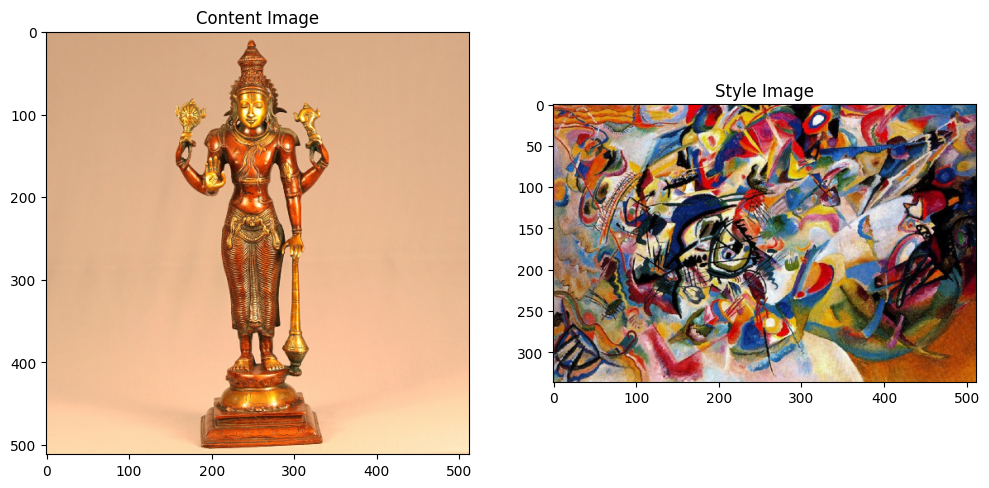

In [8]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

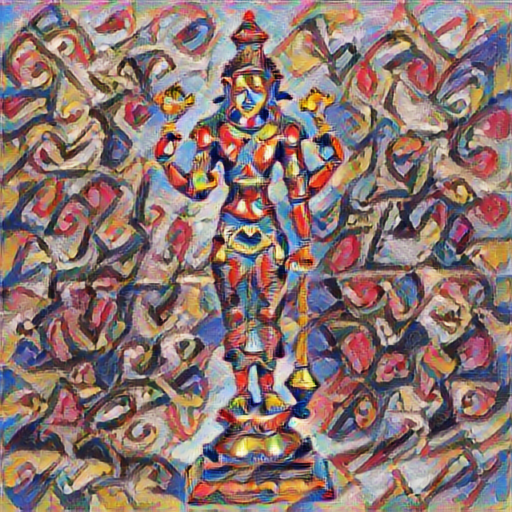

In [9]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)